In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the HMM
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.9
y_masked = y * mask

In [4]:
print("Fitting SLDS with SVI")

# Create the model and initialize its parameters
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
slds.initialize(y_masked, masks=mask)

# Create a variational posterior
q_mf = SLDSMeanFieldVariationalPosterior(slds, y_masked, masks=mask)
q_mf_elbos = slds.fit(q_mf, y_masked, masks=mask, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_mf_x, y)))
q_mf_z = slds.most_likely_states(q_mf_x, y)

# Smooth the data under the variational posterior
q_mf_y = slds.smooth(q_mf_x, y)



Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


In [5]:
print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
slds.initialize(y_masked, masks=mask)

from ssm.variational import SLDSStructuredMeanFieldVariationalPosterior
q_lem = SLDSStructuredMeanFieldVariationalPosterior(slds, y_masked, masks=mask)

q_lem_elbos = slds.fit(q_lem, y_masked, masks=mask, method="laplace_em", alpha=0.5, num_optimizer_iters=50, initialize=False)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_lem_x, y)))
q_lem_z = slds.most_likely_states(q_lem_x, y)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, y)

Fitting SLDS with Laplace-EM
Initializing with an ARHMM using 25 steps of EM.


/Users/davidzoltowski/github/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/Users/davidzoltowski/github/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))
/Users/davidzoltowski/github/ssm/ssm/optimizers.py:131: UserWarning: L-BFGS-B failed with message:
b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  warn("{} failed with message:\n{}".format(method, result.message))


In [6]:
print("Fitting SLDS with SVI using structured variational posterior")
slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
slds.initialize(y_masked, masks=mask)

q_struct = SLDSTriDiagVariationalPosterior(slds, y_masked, masks=mask)
q_struct_elbos = slds.fit(q_struct, y_masked, masks=mask, num_iters=1000, initialize=False)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_struct_x, y)))
q_struct_z = slds.most_likely_states(q_struct_x, y)

# Smooth the data under the variational posterior
q_struct_y = slds.smooth(q_struct_x, y)

Fitting SLDS with SVI using structured variational posterior
Initializing with an ARHMM using 25 steps of EM.


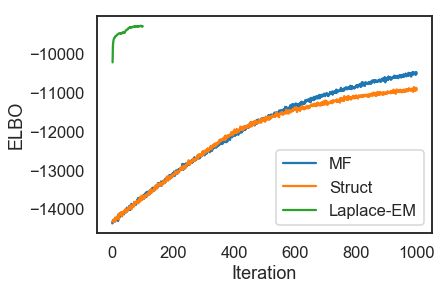

In [11]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="MF")
plt.plot(q_struct_elbos, label="Struct")
plt.plot(q_lem_elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

(0, 500)

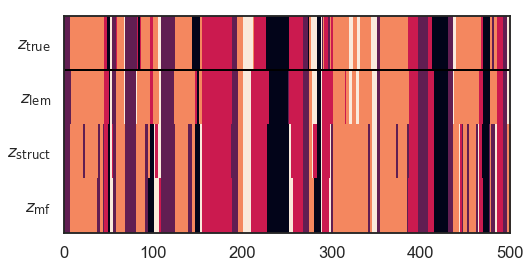

In [8]:
# Plot the true and inferred states
xlim = (0, 500)

plt.figure(figsize=(8,4))
# plt.imshow(np.row_stack((z, q_struct_z, q_mf_z)), aspect="auto")
plt.imshow(np.row_stack((z, q_lem_z, q_struct_z, q_mf_z)), aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1, 2, 3], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{lem}}$", "$z_{\\mathrm{struct}}$", "$z_{\\mathrm{mf}}$"])
plt.xlim(xlim)

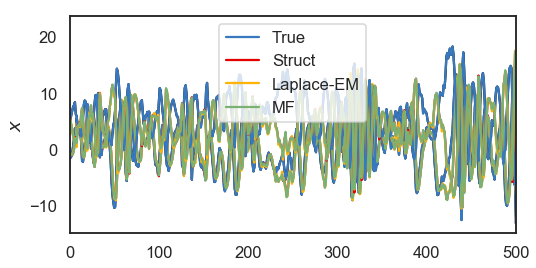

In [9]:
plt.figure(figsize=(8,4))
plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(x[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    plt.plot(q_struct_x[:,d] + 4 * d, '-', color=colors[1], label="Struct" if d==0 else None)
    plt.plot(q_lem_x[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    plt.plot(q_mf_x[:,d] + 4 * d, '-', color=colors[3], label="MF" if d==0 else None)
plt.ylabel("$x$")
plt.xlim(xlim)
plt.legend()

(0, 500)

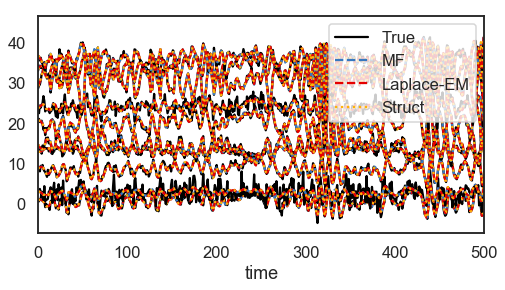

In [10]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
for n in range(N):
    plt.plot(y[:, n] + 4 * n, '-k', label="True" if n == 0 else None)
    plt.plot(q_mf_y[:, n] + 4 * n, '--', color=colors[0], label="MF" if n == 0 else None)
    plt.plot(q_lem_y[:, n] + 4 * n, '--', color=colors[1], label="Laplace-EM" if n == 0 else None)
    plt.plot(q_struct_y[:, n] + 4 * n, ':',  color=colors[2], label="Struct" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.xlim(xlim)